In [1]:
import scanpy as sc
import anndata as ad

# Data retrieval
import pooch

In [67]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = 'FALSE'

In [129]:
import pandas as pd

In [2]:
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache("scverse_tutorials"),
    base_url="doi:10.6084/m9.figshare.22716739.v1/",
)
EXAMPLE_DATA.load_registry_from_doi()

ConnectionError: HTTPSConnectionPool(host='figshare.com', port=443): Max retries exceeded with url: /articles/dataset/NeurIPS_2021_Benchmark_dataset/22716739/1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fa1c2ceb650>: Failed to establish a new connection: [Errno -2] Name or service not known'))

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.9.3 anndata==0.8.0 umap==0.5.1 numpy==1.20.3 scipy==1.7.3 pandas==1.2.4 scikit-learn==1.0.2 statsmodels==0.13.5 python-igraph==0.10.8 pynndescent==0.5.4


In [11]:
results_file = "write/pbmc3k.h5ad"

In [68]:
adata = sc.read_10x_mtx(
    "data/filtered_gene_bc_matrices/hg19/", 
    var_names="gene_symbols",
    #cache=True,
)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [69]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

normalizing counts per cell
    finished (0:00:00)


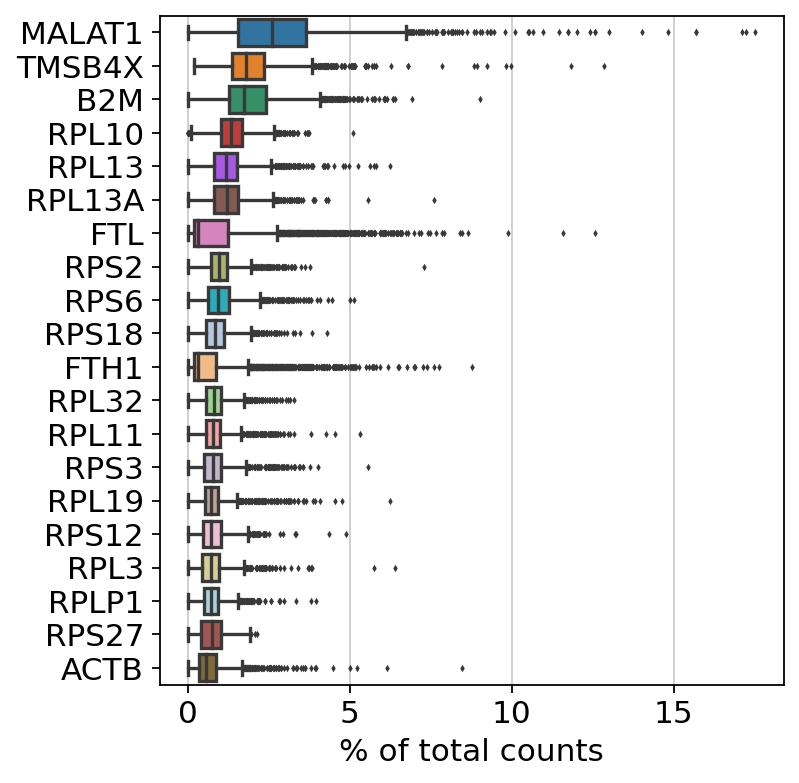

In [70]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [71]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [72]:
adata.var_names.str.startswith("MT-").shape
adata.shape

(2700, 13714)

In [73]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

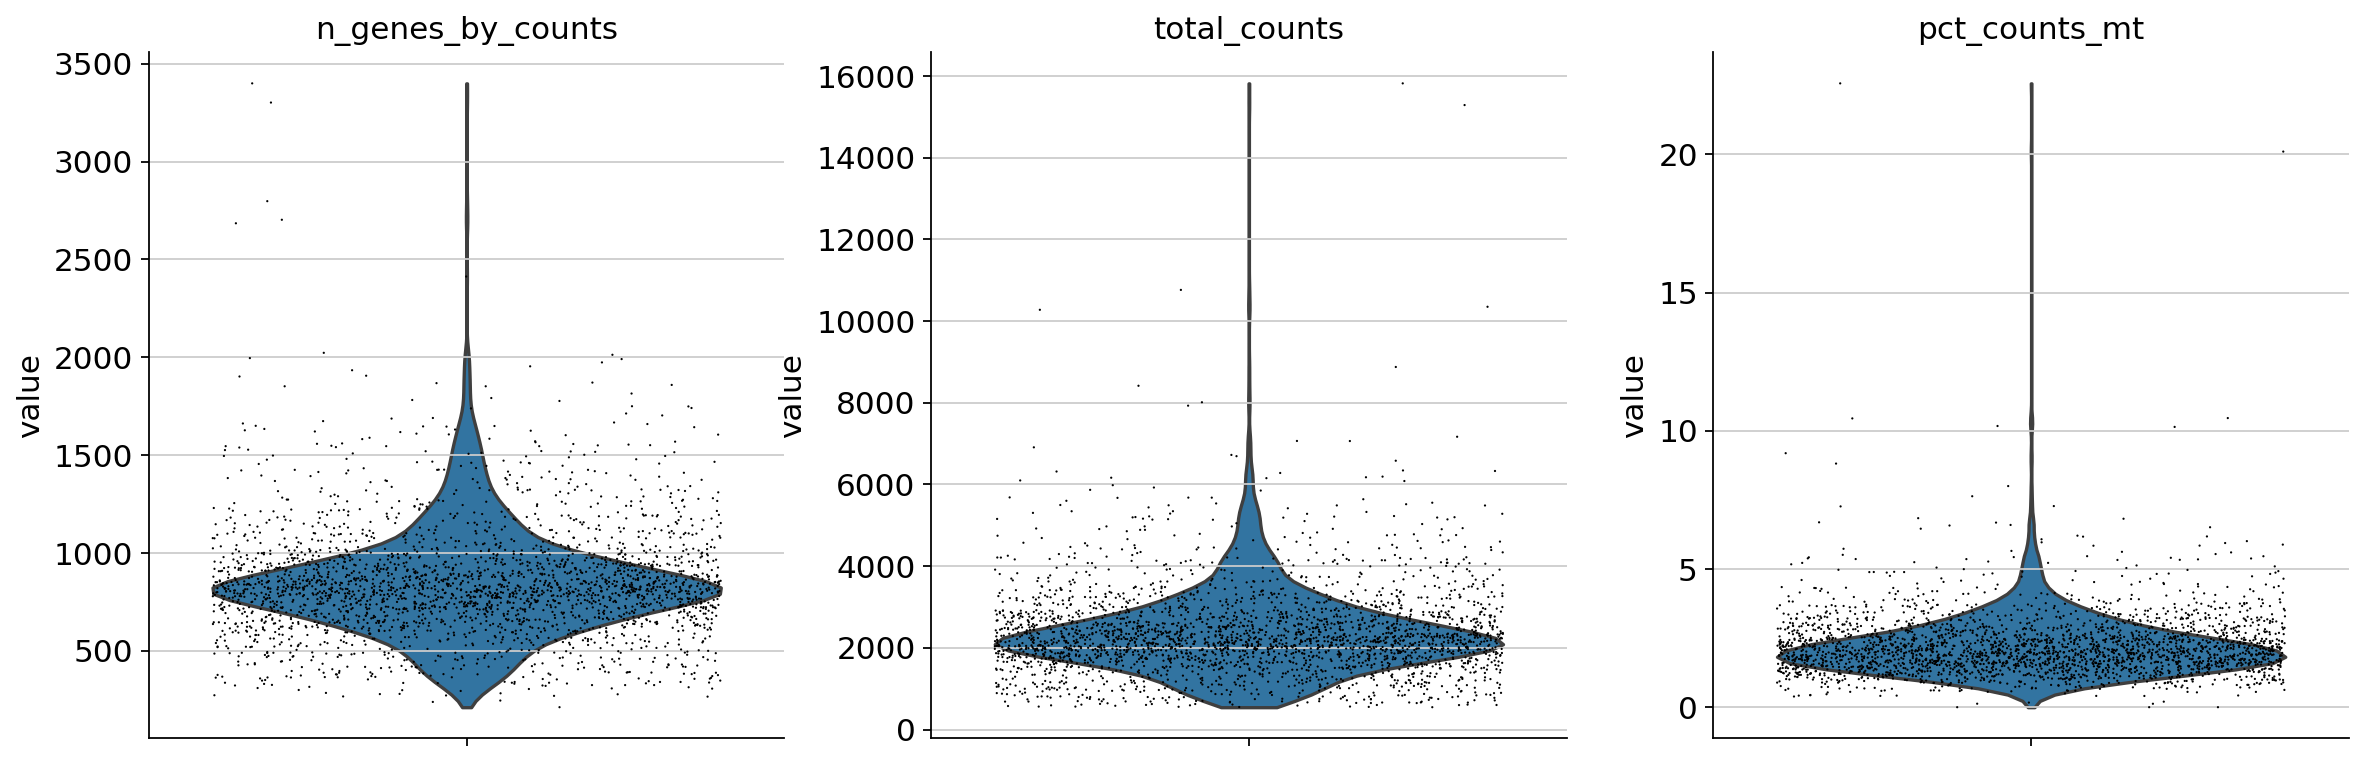

In [74]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [75]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

In [76]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [77]:
adata.write_h5ad('abc.')

In [78]:
sc.pp.log1p(adata)

In [79]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


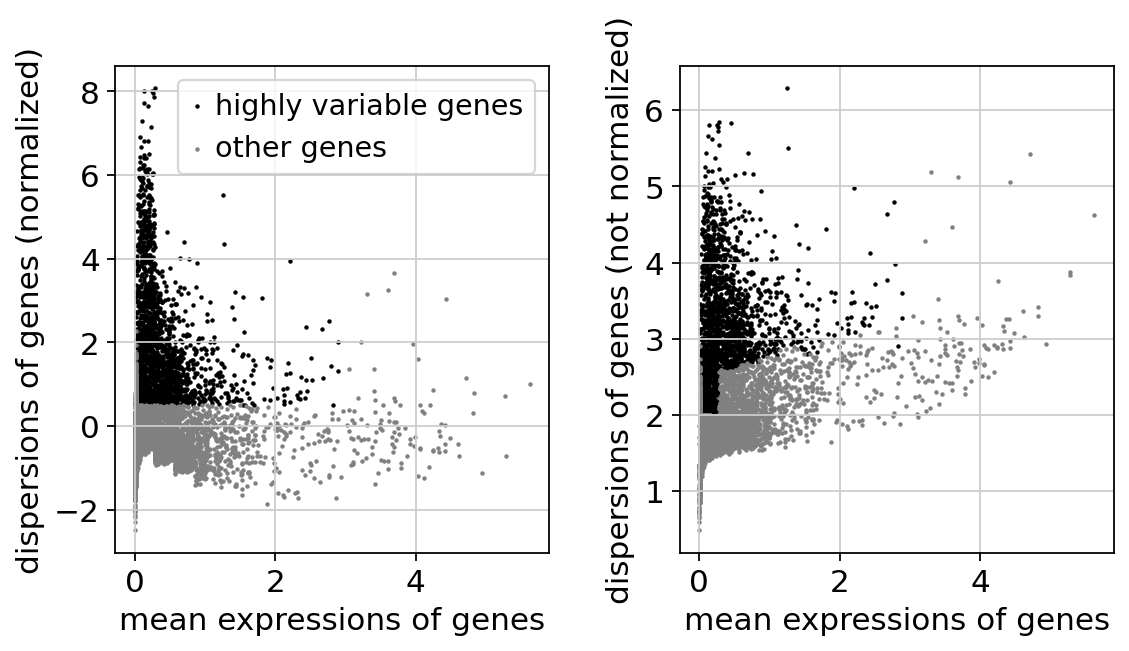

In [80]:
sc.pl.highly_variable_genes(adata)

In [81]:
adata.raw = adata

In [82]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [83]:
adata = adata[:, adata.var.highly_variable]

In [84]:
adata

View of AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [85]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:06)


In [86]:
sc.pp.scale(adata, max_value=10)

In [87]:
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


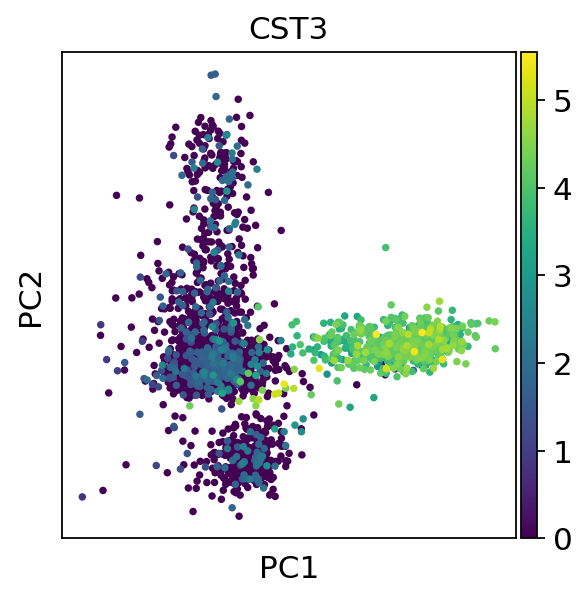

In [88]:
sc.pl.pca(adata, color="CST3")

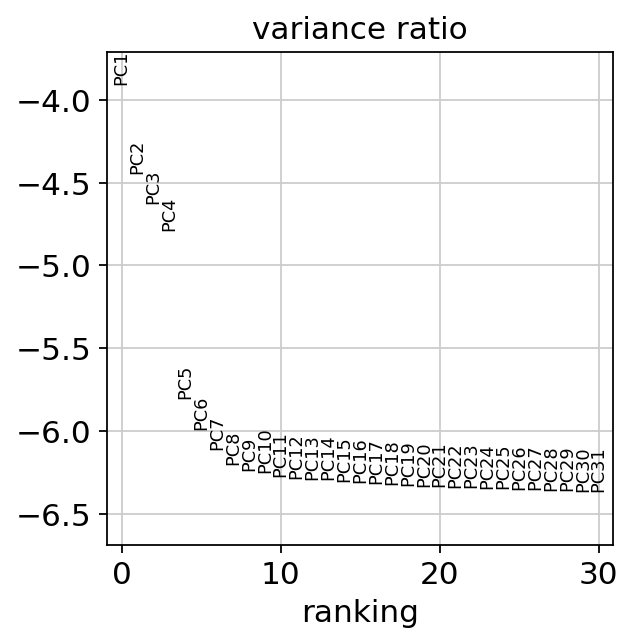

In [89]:
sc.pl.pca_variance_ratio(adata, log=True)

In [92]:
#fn = 'test.h5ad'
adata.write('data/write/pbmc3k.h5ad')

In [93]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [94]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [96]:
sc.tl.paga(adata,groups='leiden')
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

KeyError: "`groups` key 'leiden' not found in `adata.obs`."

In [97]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [98]:
sc.tl.leiden(adata, key_added="leiden_res0_25", resolution=0.25)
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res1", resolution=1.0)
sc.tl.leiden(adata, key_added="leiden_res2", resolution=2.0)

running Leiden clustering
    finished: found 5 clusters and added
    'leiden_res0_25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden_res0_5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res1', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 22 clusters and added
    'leiden_res2', the cluster labels (adata.obs, categorical) (0:00:00)


In [99]:
import omicverse as ov

ModuleNotFoundError: No module named 'omicverse'

In [100]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


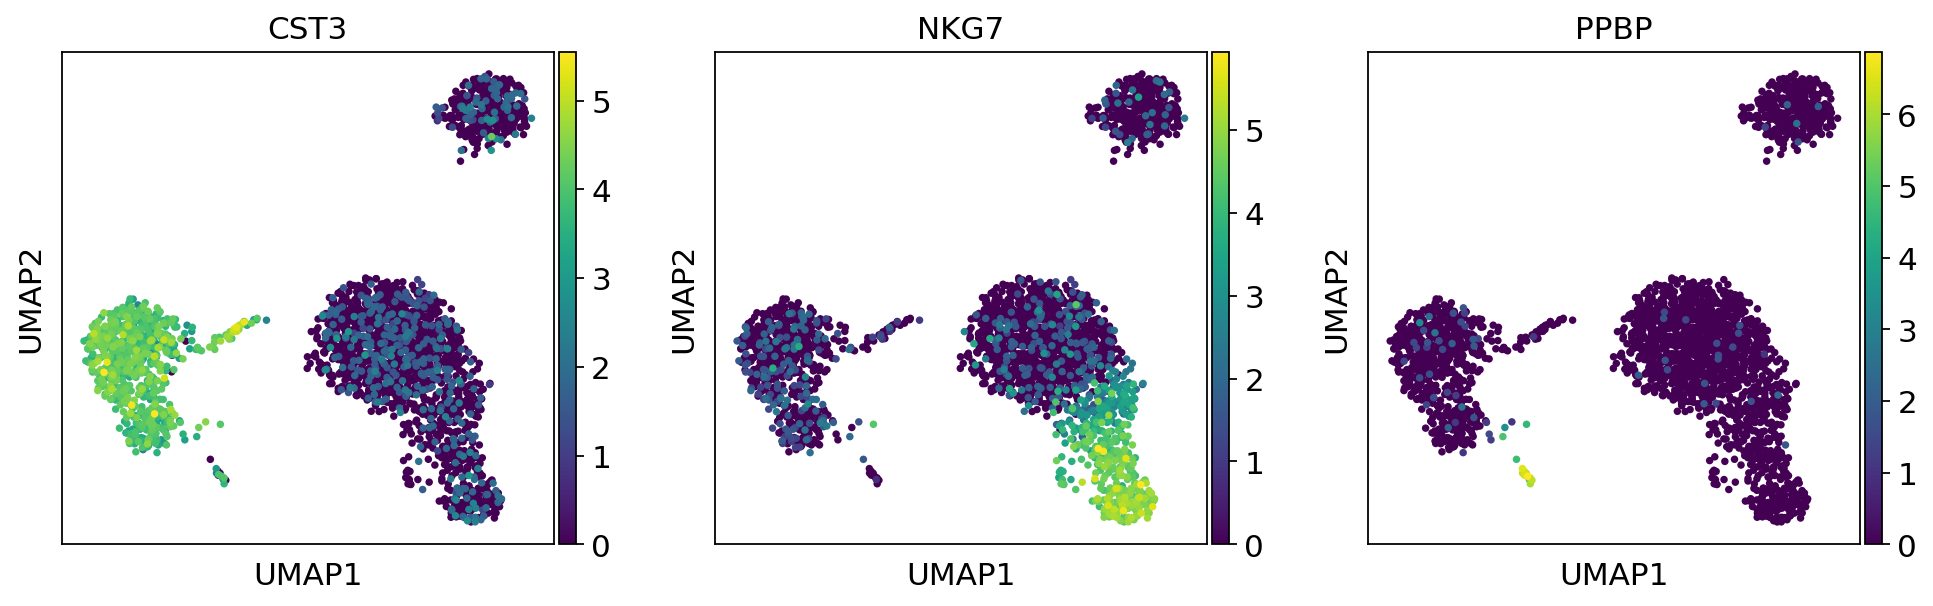

In [102]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"])

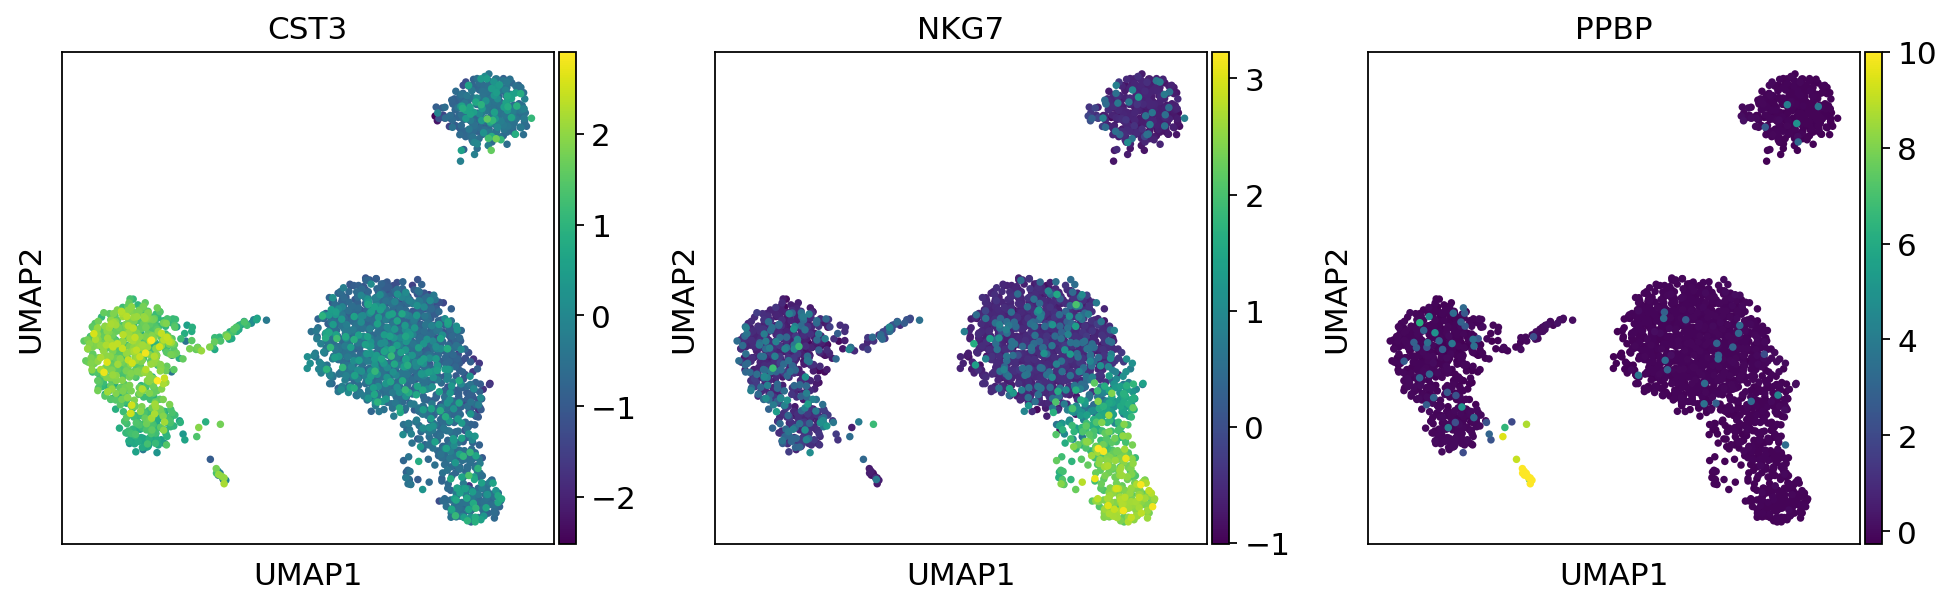

In [103]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"], use_raw=False)

In [116]:
sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
    #flavor="ipgraph",
    n_iterations=2,
    directed=False,
)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [117]:
sc.__version__

'1.9.3'

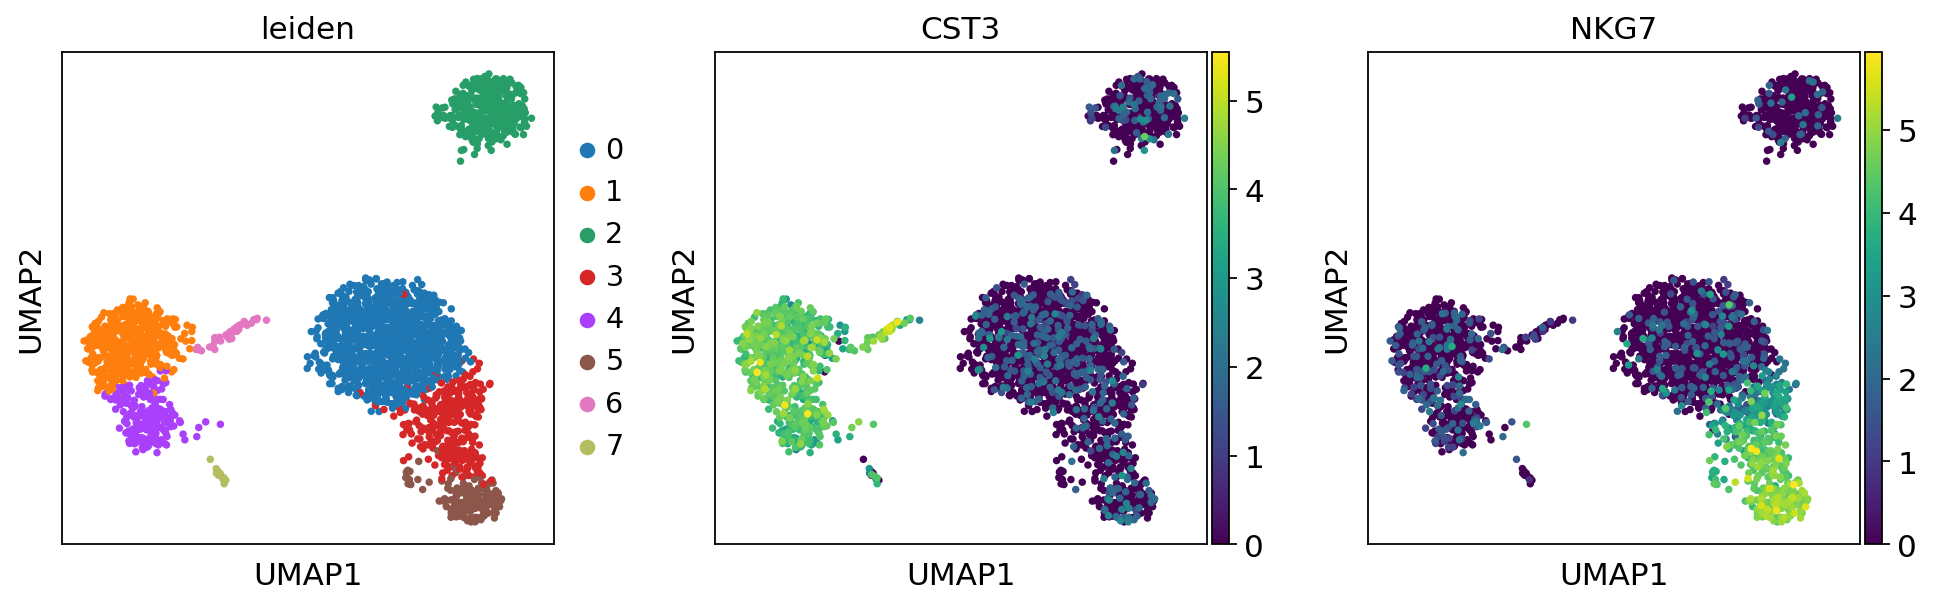

In [118]:
sc.pl.umap(adata, color=["leiden", "CST3", "NKG7"])

In [119]:
#fn = 'test.h5ad'
adata.write('data/write/pbmc3k.h5ad')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


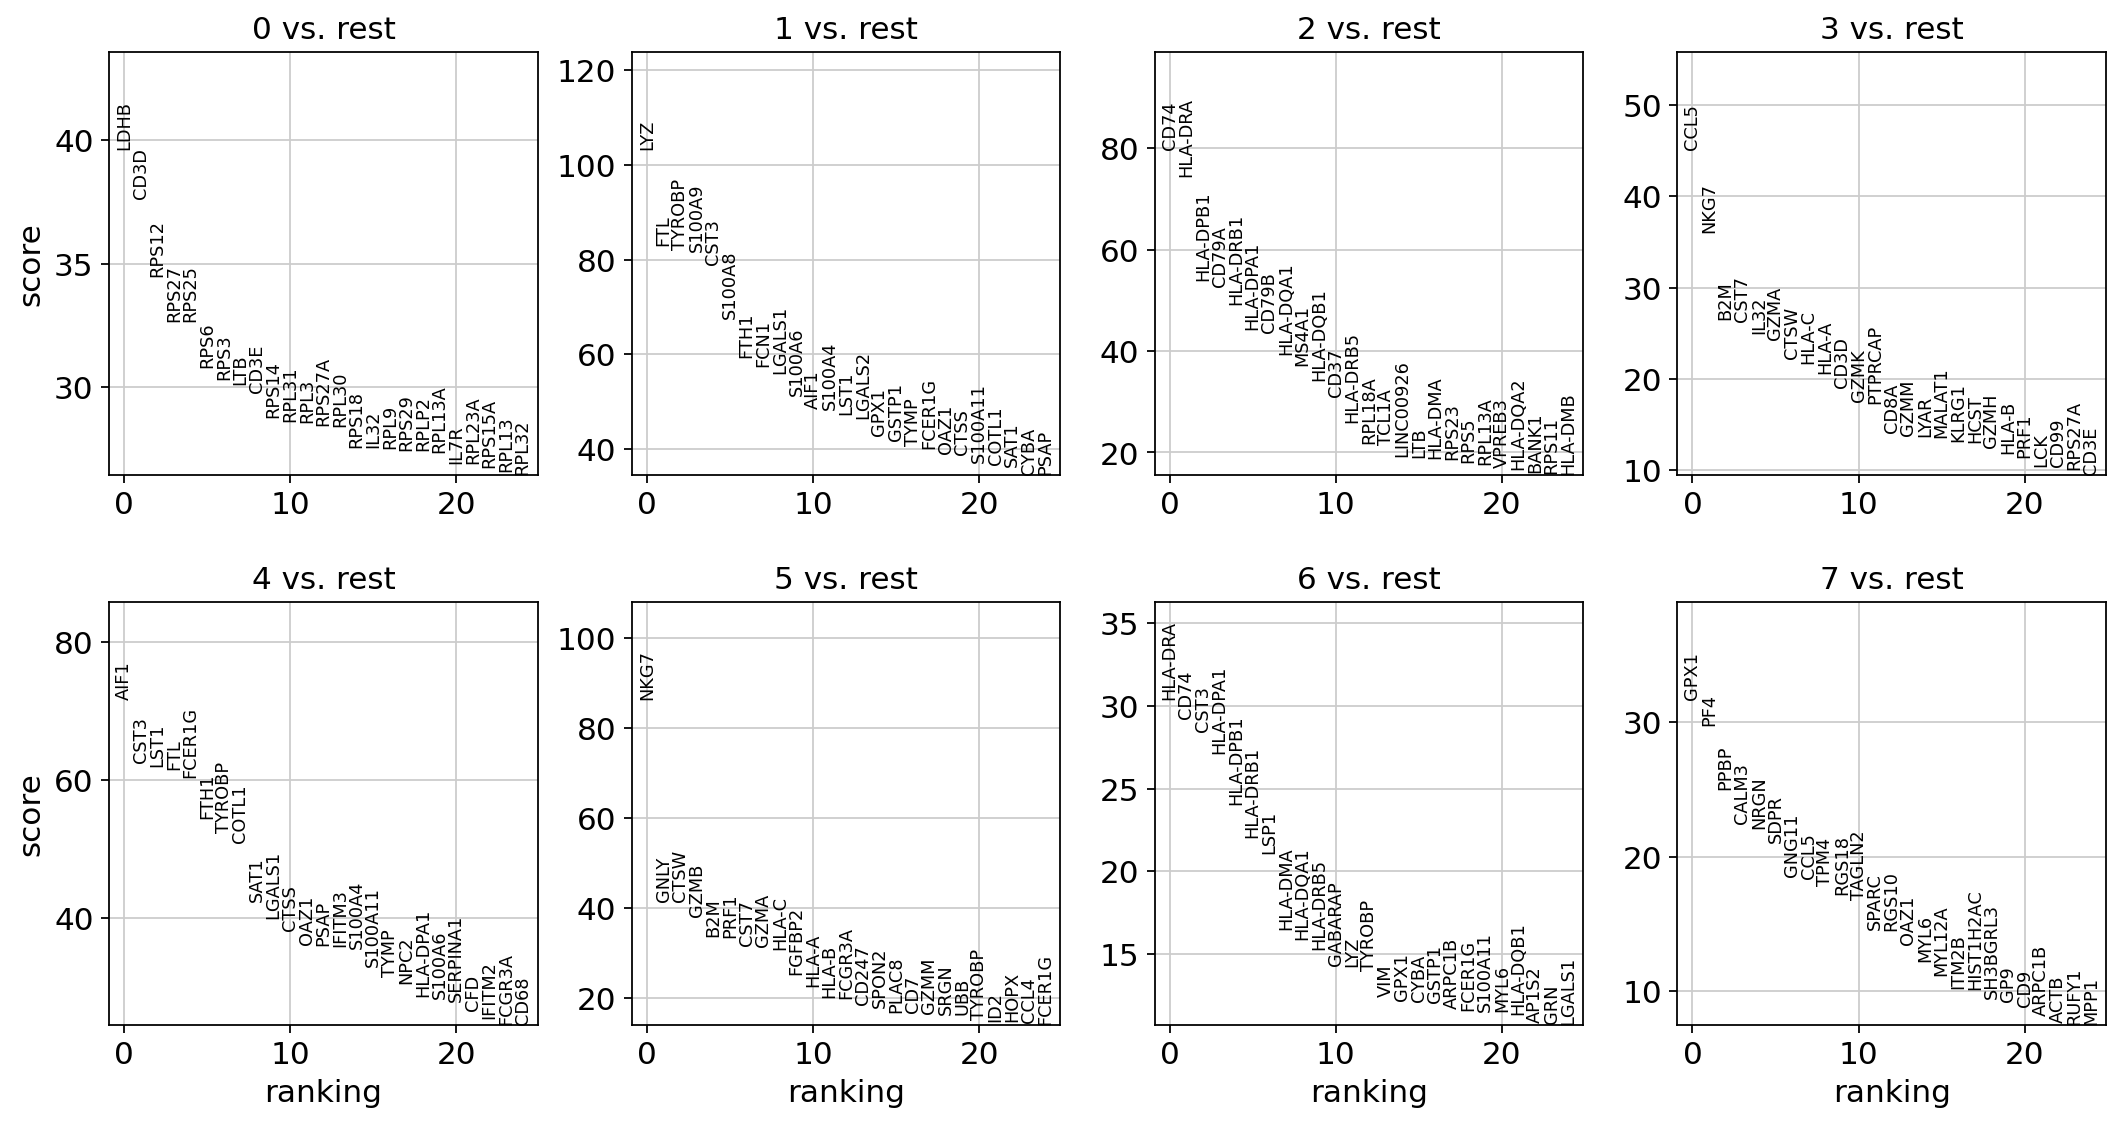

In [120]:
sc.tl.rank_genes_groups(adata, "leiden", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


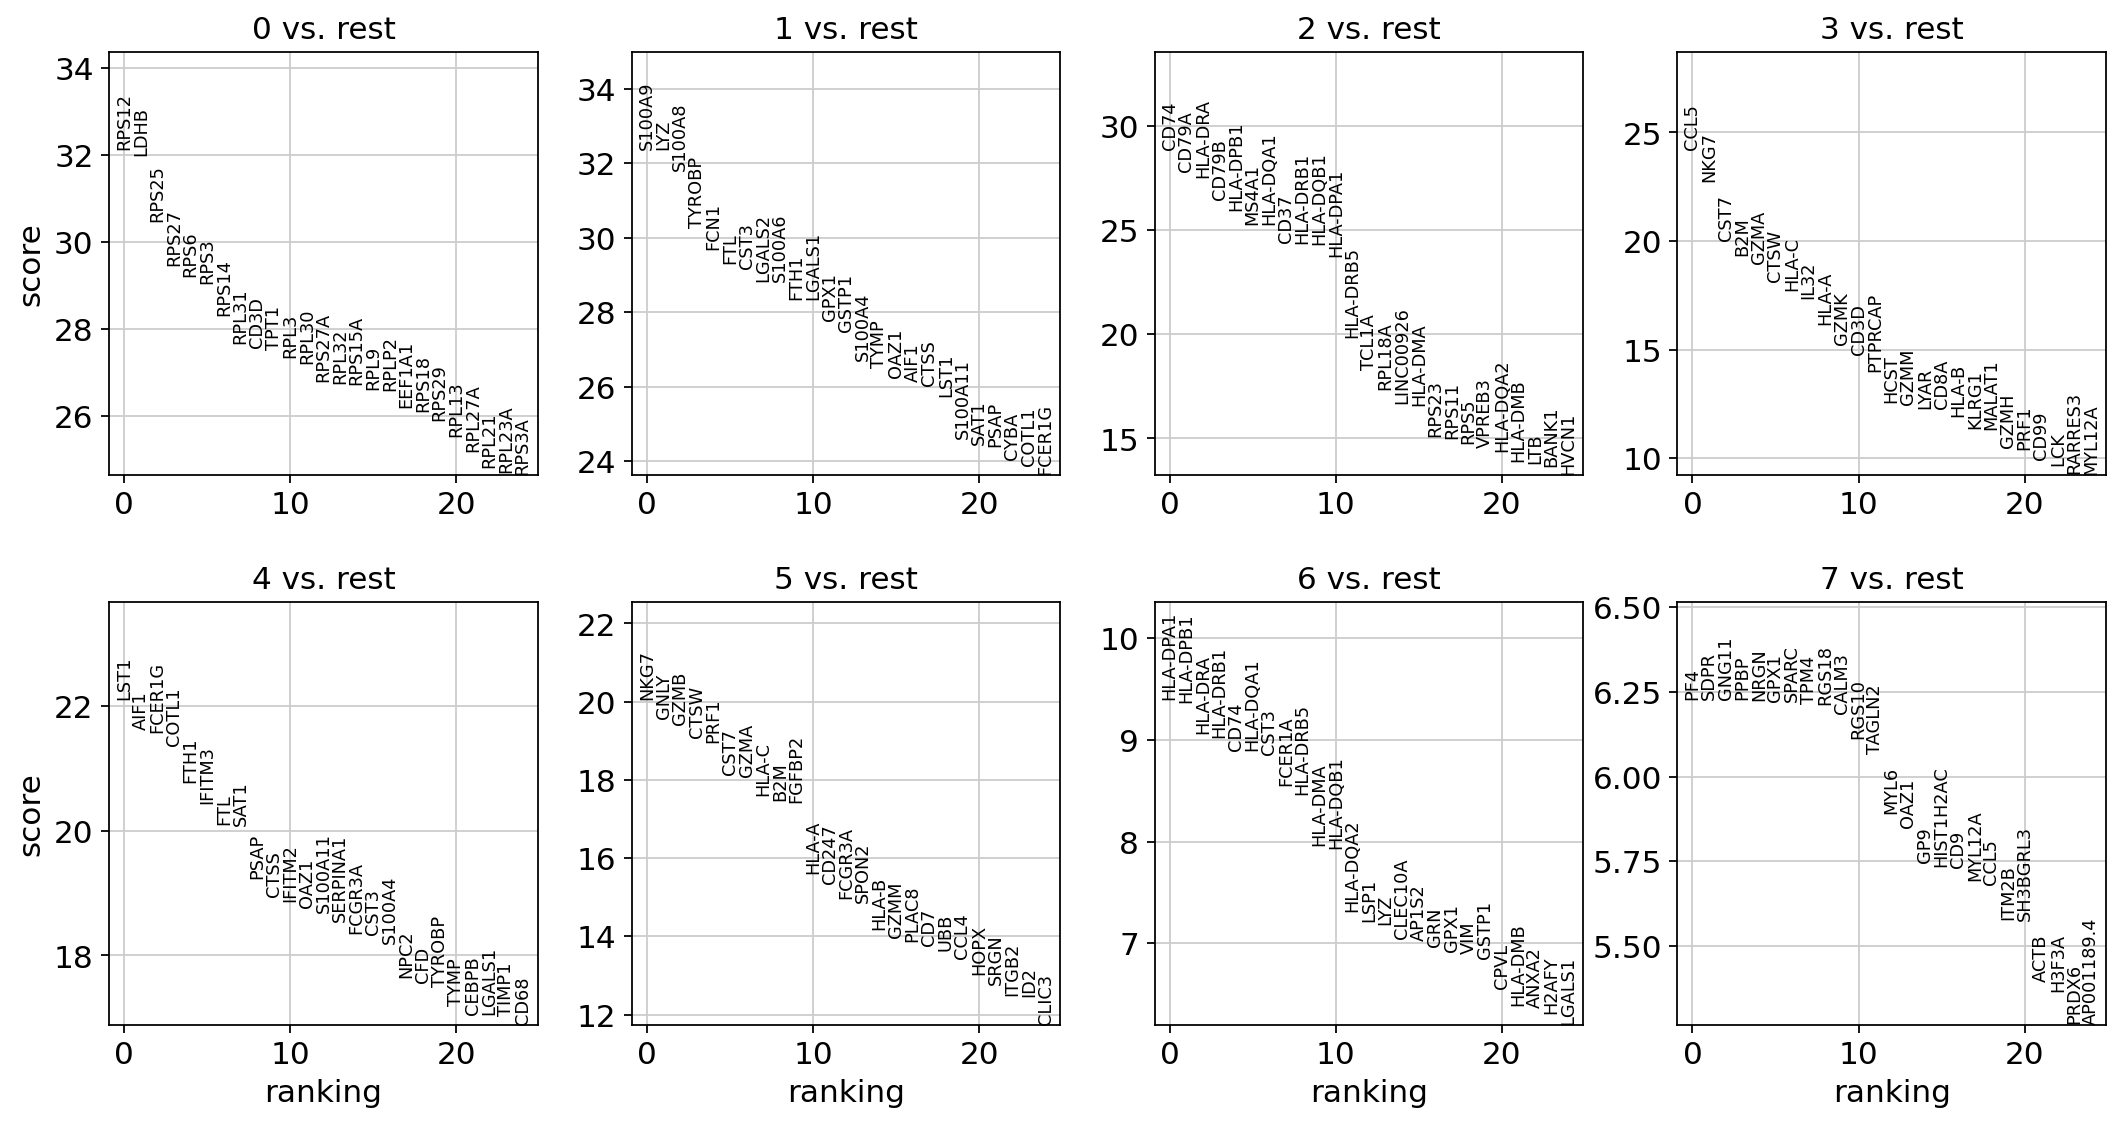

In [121]:
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [122]:
#fn = 'test.h5ad'
adata.write('data/write/pbmc3k.h5ad')

In [123]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1', 'leiden_res2'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [125]:
adata.uns['rank_genes_groups']

{'params': {'groupby': 'leiden',
  'reference': 'rest',
  'method': 'wilcoxon',
  'use_raw': True,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('RPS12', 'S100A9', 'CD74', 'CCL5', 'LST1', 'NKG7', 'HLA-DPA1', 'PF4'),
            ('LDHB', 'LYZ', 'CD79A', 'NKG7', 'AIF1', 'GNLY', 'HLA-DPB1', 'SDPR'),
            ('RPS25', 'S100A8', 'HLA-DRA', 'CST7', 'FCER1G', 'GZMB', 'HLA-DRA', 'GNG11'),
            ...,
            ('HLA-DRA', 'RPS27', 'S100A6', 'RPS11', 'RPL13A', 'RPL28', 'RPL21', 'RPL11'),
            ('CYBA', 'RPS27A', 'TMSB4X', 'FTH1', 'RPL13', 'RPL32', 'RPS27', 'MALAT1'),
            ('CD74', 'MALAT1', 'S100A4', 'TMSB10', 'RPL3', 'RPL18A', 'MALAT1', 'RPL10')],
           dtype=[('0', 'O'), ('1', 'O'), ('2', 'O'), ('3', 'O'), ('4', 'O'), ('5', 'O'), ('6', 'O'), ('7', 'O')]),
 'scores': rec.array([( 32.12962 ,  32.37109 ,  28.874624,  24.222727,  22.104856,  20.06321 ,  9.400656 ,  6.228046 ),
            ( 31.987621,  32.368614,  27.834063,  22.72958 

In [126]:
marker_genes = [
    *["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"],
]

In [127]:
marker_genes

['IL7R',
 'CD79A',
 'MS4A1',
 'CD8A',
 'CD8B',
 'LYZ',
 'CD14',
 'LGALS3',
 'S100A8',
 'GNLY',
 'NKG7',
 'KLRB1',
 'FCGR3A',
 'MS4A7',
 'FCER1A',
 'CST3',
 'PPBP']

In [133]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(5)

,0,1,2,3,4,5,6,7
0,RPS12,S100A9,CD74,CCL5,LST1,NKG7,HLA-DPA1,PF4
1,LDHB,LYZ,CD79A,NKG7,AIF1,GNLY,HLA-DPB1,SDPR
2,RPS25,S100A8,HLA-DRA,CST7,FCER1G,GZMB,HLA-DRA,GNG11
3,RPS27,TYROBP,CD79B,B2M,COTL1,CTSW,HLA-DRB1,PPBP
4,RPS6,FCN1,HLA-DPB1,GZMA,FTH1,PRF1,CD74,NRGN


In [134]:
adata.uns["rank_genes_groups"]["names"]

rec.array([('RPS12', 'S100A9', 'CD74', 'CCL5', 'LST1', 'NKG7', 'HLA-DPA1', 'PF4'),
           ('LDHB', 'LYZ', 'CD79A', 'NKG7', 'AIF1', 'GNLY', 'HLA-DPB1', 'SDPR'),
           ('RPS25', 'S100A8', 'HLA-DRA', 'CST7', 'FCER1G', 'GZMB', 'HLA-DRA', 'GNG11'),
           ...,
           ('HLA-DRA', 'RPS27', 'S100A6', 'RPS11', 'RPL13A', 'RPL28', 'RPL21', 'RPL11'),
           ('CYBA', 'RPS27A', 'TMSB4X', 'FTH1', 'RPL13', 'RPL32', 'RPS27', 'MALAT1'),
           ('CD74', 'MALAT1', 'S100A4', 'TMSB10', 'RPL3', 'RPL18A', 'MALAT1', 'RPL10')],
          dtype=[('0', 'O'), ('1', 'O'), ('2', 'O'), ('3', 'O'), ('4', 'O'), ('5', 'O'), ('6', 'O'), ('7', 'O')])

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


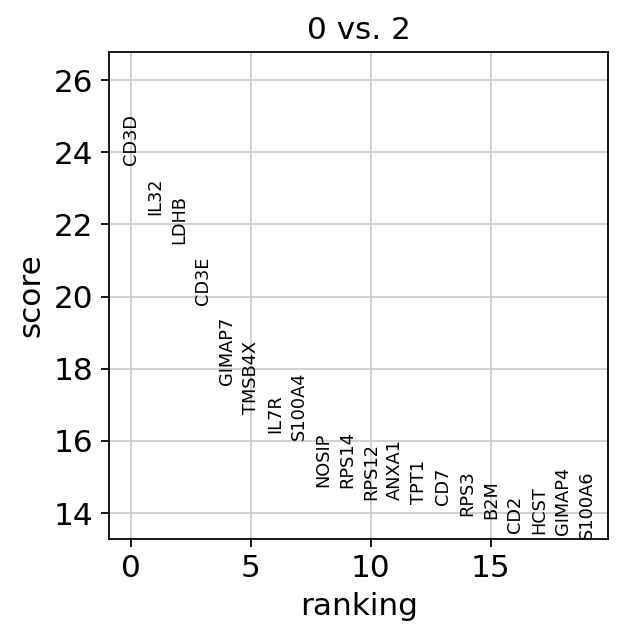

In [145]:
sc.tl.rank_genes_groups(adata, "leiden", groups=["0"], reference="2", method="wilcoxon")
sc.pl.rank_genes_groups(adata, groups=["0"], n_genes=20)
#sc.tl.rank_genes_groups(adata, "leiden", groups=["0","2","7"], reference="1", method="wilcoxon")
#sc.pl.rank_genes_groups(adata, groups=["0","2","7"], n_genes=20)

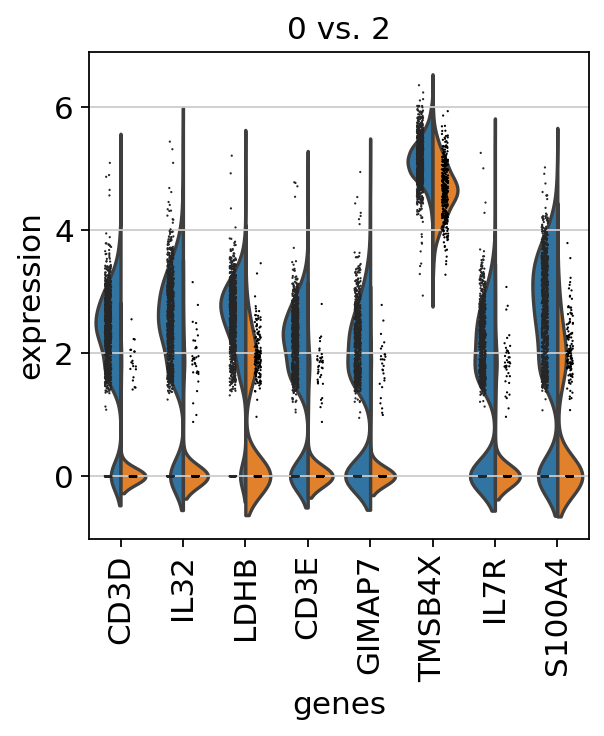

In [146]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

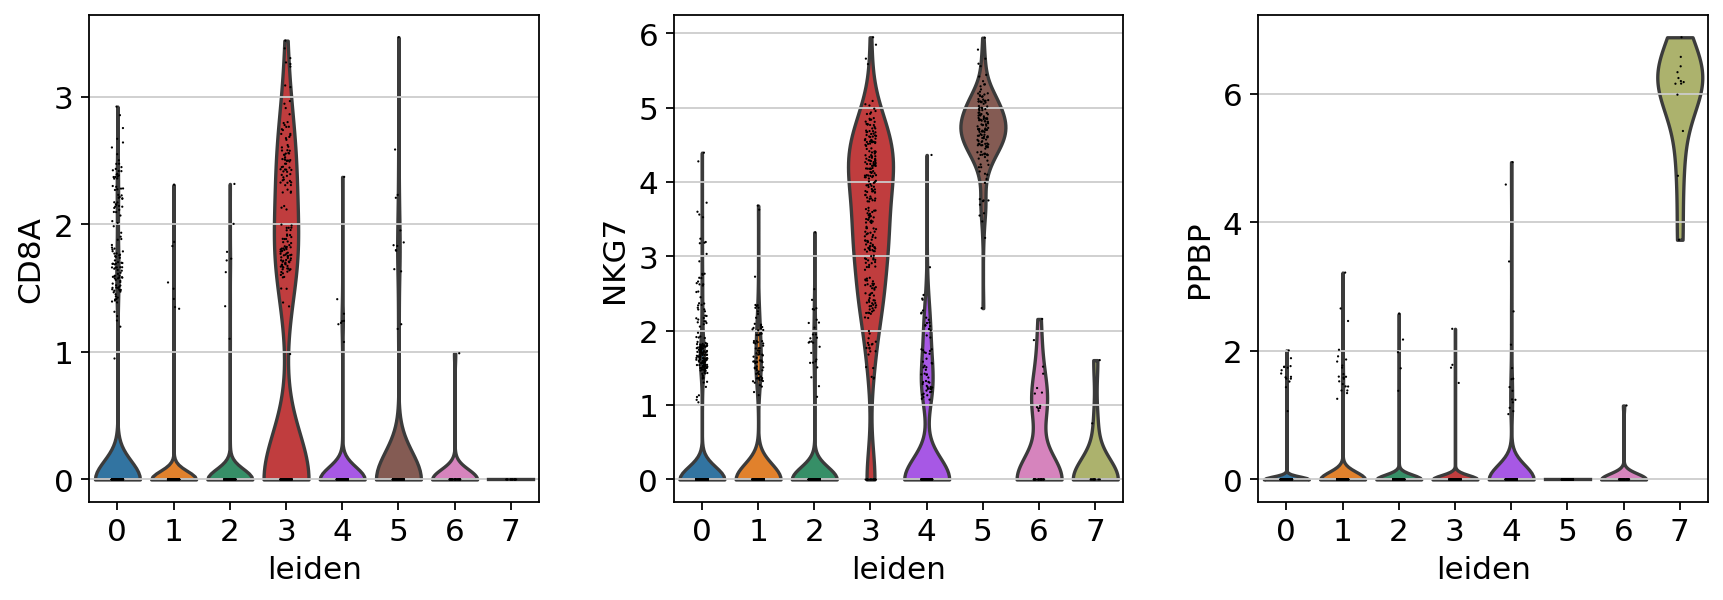

In [149]:
sc.pl.violin(adata, ["CD8A", "NKG7", "PPBP"], groupby="leiden")

In [150]:
new_cluster_names = [
    "CD4 T",
    "B",
    "FCGR3A+ Monocytes",
    "NK",
    "CD8 T",
    "CD14+ Monocytes",
    "Dendritic",
    "Megakaryocytes",
]
adata.rename_categories("leiden", new_cluster_names)

Omitting rank_genes_groups/names as old categories do not match.
Omitting rank_genes_groups/scores as old categories do not match.
Omitting rank_genes_groups/pvals as old categories do not match.
Omitting rank_genes_groups/pvals_adj as old categories do not match.
Omitting rank_genes_groups/logfoldchanges as old categories do not match.


In [157]:
adata.uns.leiden

AttributeError: 'OverloadedDict' object has no attribute 'leiden'

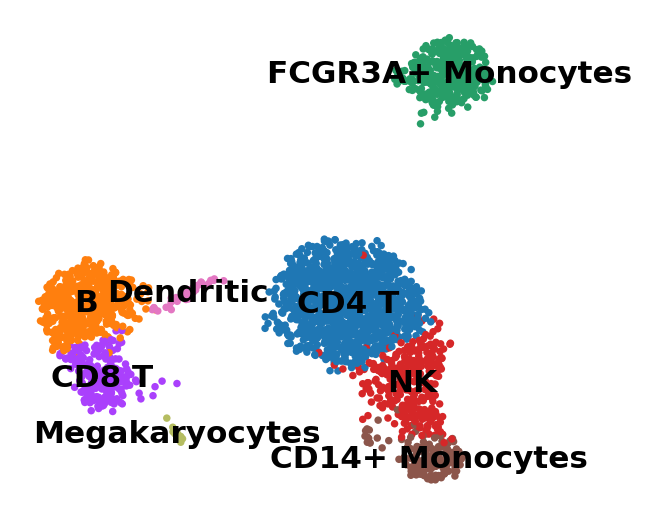

In [158]:
sc.pl.umap(
    adata, color="leiden", legend_loc="on data", title="", frameon=False, save=".pdf"
)

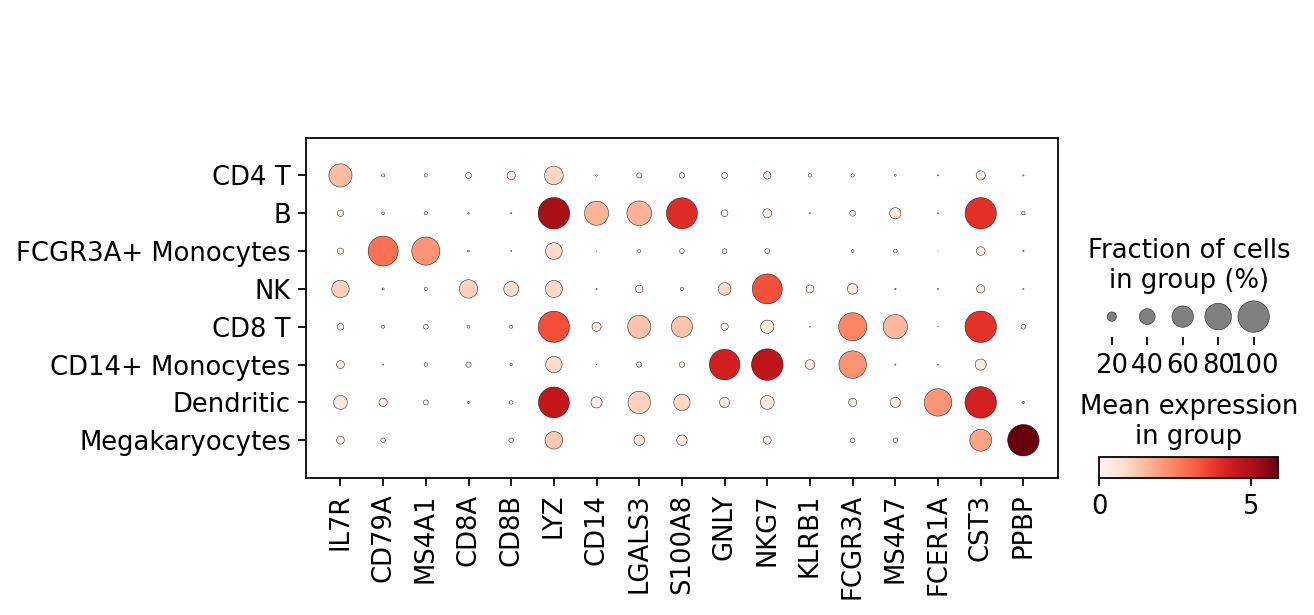

In [164]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden");

In [165]:
#fn = 'test.h5ad'
adata.write('data/write/pbmc3k.h5ad', compression="gzip")

In [166]:
del adata